In [1]:
# import libraries
import torch
import torch.distributions as D
import torch.nn.functional as F

from scipy.stats import norm, uniform
from scipy.stats import multivariate_normal as mvn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from nde.train import train
from nde.flows import construct_maf, count_parameters
from plot import PP_plot_1D, plot_2d_pdf_contours, PP_vals

from diagnostics.localPIT_regression import multiPIT_regression_baseline, infer_multiPIT_r_alphas_baseline
from diagnostics.confidence_regions import highest_density, highest_density_level
from diagnostics.multi_local_test import compute_test_statistic

import os


## 3D gaussian distribution

Target data: $\mathbf{x}=(x_1,x_2, x_3) \sim f_{\mathbf{x}}$.

Target distribution: 3D gaussian $f_{\mathbf{x}} = \mathcal{N}(\mu,\Sigma)$ where $\mu = [\mu_1, \mu_2, \mu_3]$ and 
$\Sigma = \begin{pmatrix} \sigma_{1}^2 & \rho_{1,2} \sigma_1 \sigma_2 & \rho_{1,3} \sigma_1 \sigma_3\\ \rho_{1,2} \sigma_1 \sigma_2 & \sigma_{2}^2 & \rho_{2,3} \sigma_2 \sigma_3 \\ \rho_{1,3} \sigma_1 \sigma_3 & \rho_{2,3} \sigma_2 \sigma_3 & \sigma_{3}^2 \end{pmatrix}$.

We also define a *false* distribution, where we rotate the covariance matrix around the 3rd data-dimension ($x_3$-axis) by an angle $\psi \in [0, \pi/2]$, to investigate whether our diagnostics (multiPIT) cn capture this mismatch between distributions (and compare it to HDR):

$$ \Sigma_{false} = R(\psi)\Sigma R(\psi)^T \quad \text{with} \quad R(\psi) = \begin{pmatrix} \cos(\psi) & -\sin(\psi) & 0 \\ \sin(\psi) & \cos(\psi) & 0 \\ 0 & 0 & 1 \end{pmatrix}.$$ 

### Data 

#### Define Data Distributions 

In [2]:
# Parameters of the distribution
mu_1 = 0
mu_2 = 0
mu_3 = 0
sigma_1 = 1
sigma_2 = 1
sigma_3 = 1
rho_12 = 0.8
rho_13 = 0
rho_23 = 0

# True distribution: 3d gaussian
mean = np.array([mu_1, mu_2, mu_3])
covariance = np.array(
    [
        [sigma_1 ** 2, rho_12 * sigma_1 * sigma_2, rho_13 * sigma_1 * sigma_3],
        [rho_12 * sigma_1 * sigma_2, sigma_2 ** 2, rho_23 * sigma_2 * sigma_3],
        [rho_13 * sigma_1 * sigma_3, rho_23 * sigma_2 * sigma_3, sigma_2 ** 3],
    ]
)
multi_normal_dist = mvn(mean=mean, cov=covariance)

# "False distribution": 3d gaussian with same mean and rotated covariance matrix
# (by \psi around the 3rd dimension x_3)

def rotation_matrix(angle):
    return np.array(
        [
            [np.cos(angle), -np.sin(angle), 0],
            [np.sin(angle), np.cos(angle), 0],
            [0, 0, 1],
        ]
    )

mean_false = np.array([mu_1, mu_2, mu_3])
angles = np.linspace(0, np.pi/2, 10)
covariance_false_list = [
    np.matmul(np.matmul(rotation_matrix(angle), covariance), rotation_matrix(angle).T)
    for angle in angles
]
false_mvns_list = [
    mvn(mean=mean_false, cov=cov_false) for cov_false in covariance_false_list
]


#### Plot Data Distributions

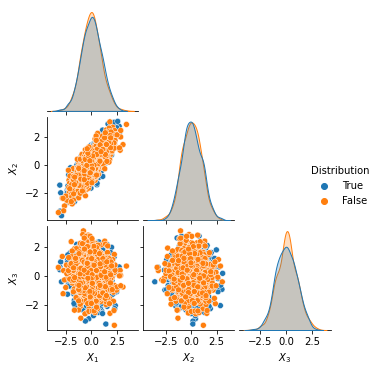

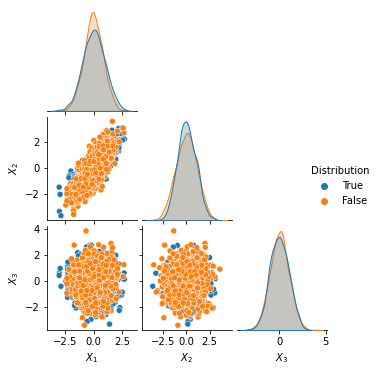

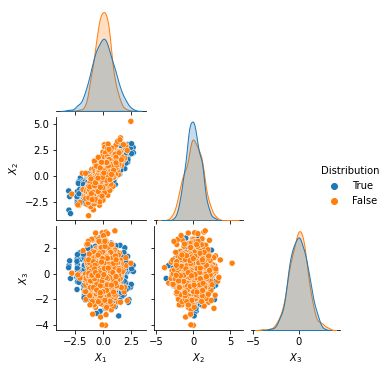

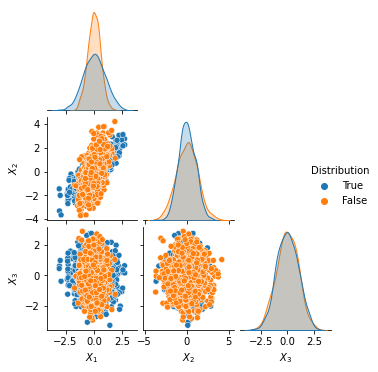

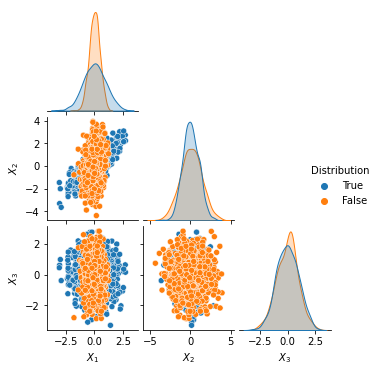

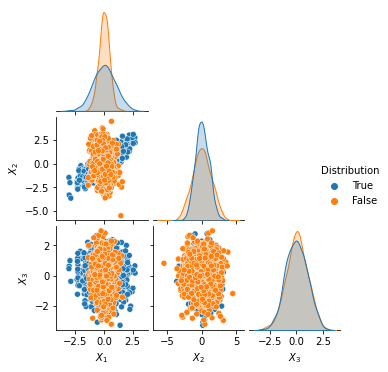

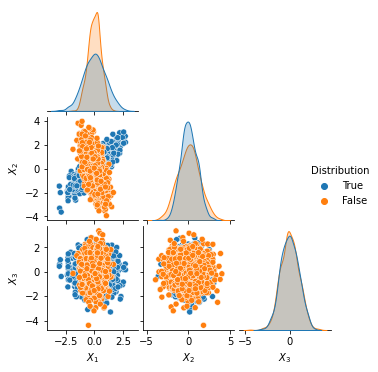

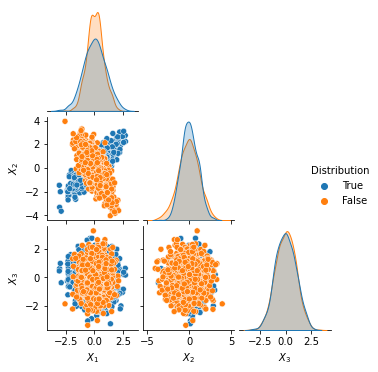

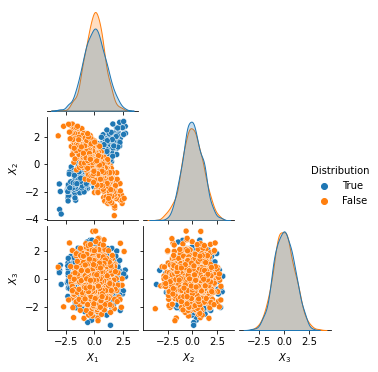

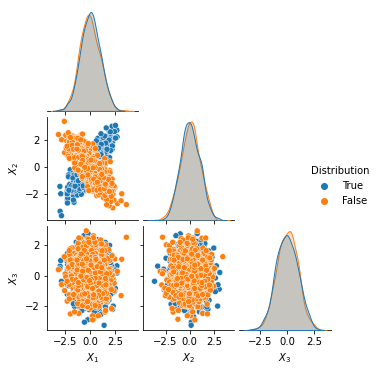

In [3]:
# Plot distribution and PP-plots of the target distribution and the learned maf

# Pairplot
columns = [r"$X_1$", r"$X_2$", r"$X_3$"]
colors = ['blue', 'orange']

n = 1_000
samples_true = multi_normal_dist.rvs(n)
df_true = pd.DataFrame(samples_true, columns=columns)
df_true["Distribution"] = "True"

for i in range(len(angles)):
    samples_false = false_mvns_list[i].rvs(n)
    df_maf = pd.DataFrame(samples_false, columns=columns)
    df_maf["Distribution"] = "False"

    dfs = pd.concat([df_true, df_maf], ignore_index=True)

    g = sns.pairplot(dfs, hue="Distribution", corner=True)
    # g.fig.suptitle("rotation angle = "+str(thetas[i]))
    g.fig.set_size_inches(5,5)
    plt.show()


#### Generate Samples

$\mathbf{x} = (x_1, x_2, x_3) \sim f_\mathbf{x} = \mathcal{N}(\mu, \Sigma)$: non-rotated distribution used to train the flow.

In [4]:
# Define target distribution
means = torch.FloatTensor(mean)  # Defined in previous section
covs = torch.FloatTensor(covariance)  # Defined in previous section
target_dist = D.multivariate_normal.MultivariateNormal(means, covs)

# Get train and test samples:
# - train samples are used to train the flow,
# - cal samples are used to train the regressors 
# - test samples are used to plot the pp-plots (evaluate the regressors).
train_size = 10_000
cal_size = 5_000
test_size = 1_000

filename = 'saved_experiments/Gaussian3D_multiPIT/datasets.pkl'
if os.path.exists(filename):
    datasets = torch.load(filename)
else:
    x_samples_train, x_samples_cal, x_samples_test = target_dist.sample((train_size,)), target_dist.sample((cal_size,)), target_dist.sample((test_size,))
    datasets = {'train': x_samples_train, 'cal': x_samples_cal, 'test':x_samples_test}
    torch.save(datasets, filename)

print("NB training samples: ", datasets['train'].shape)
print("NB calibration samples: ", datasets['cal'].shape)
print("NB test samples: ", datasets['test'].shape)

NB training samples:  torch.Size([10000, 3])
NB calibration samples:  torch.Size([5000, 3])
NB test samples:  torch.Size([1000, 3])


### Train Normalizing Flow 
MAF with 4 layers and Reverse Permutation, such that at the end the $i^{th}$ element of the flow transformation corresponds to the $i^{th}$ data coordinate.

In [5]:
# Define Flow: MAF (3 layer, 50 hidden features)
maf = construct_maf(
    datasets['train'],
    hidden_features=50,
    context_features=None,
    num_layers=4,
    random_permutation=False,
    standardize_transform=True,
)

# look at permutations inside maf-transformation
x_new = datasets['train'][:1]
print(x_new)
for i in range(3):
    x_new = maf._transform._transforms[1]._transforms[i*2](x_new)[0]
    print(x_new)

tensor([[-0.8621, -0.3590,  1.4831]])
tensor([[ 1.4831, -0.3590, -0.8621]])
tensor([[-0.8621, -0.3590,  1.4831]])
tensor([[ 1.4831, -0.3590, -0.8621]])


In [6]:
import os
filename = f'saved_experiments/Gaussian3D_multiPIT/maf_n_layers_4_n_{train_size}.pkl'
if os.path.exists(filename):
    # Load Trained Flow
    maf = torch.load(filename)
else:
    # Train Flow
    best_val_loss, epochs = train(
        maf,
        datasets['train'],
        num_epochs=2000,
        batch_size=10,
        lr=0.005,
        validation=True,
        plot=False,
        epochs_until_converge=20,
    )
    torch.save(maf,filename)

## Eval on TRUE data distribution

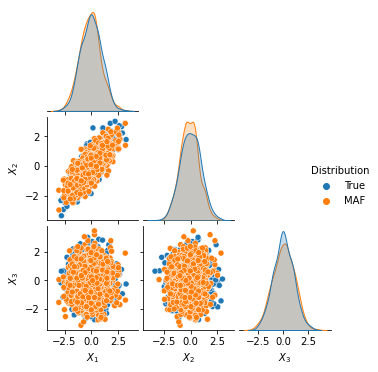

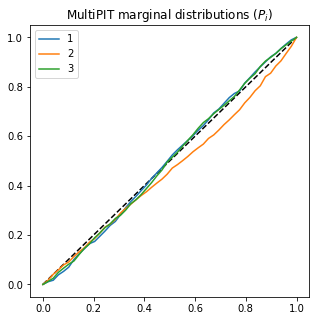

In [7]:
# Plot distribution and PP-plots of the target distribution and the learned maf

# Pairplot
columns = [r"$X_1$", r"$X_2$", r"$X_3$"]
colors = ['blue', 'orange']

samples_true = np.array(datasets['test'])
df_true = pd.DataFrame(samples_true, columns=columns)
df_true["Distribution"] = "True"

maf_samples = maf.sample(test_size)
df_maf = pd.DataFrame(maf_samples.detach().numpy(), columns=columns)
df_maf["Distribution"] = "MAF"

dfs = pd.concat([df_true, df_maf], ignore_index=True)

g = sns.pairplot(dfs, hue="Distribution", corner=True)
g.fig.set_size_inches(5,5)
plt.show()

# MAF transformation
P_1_maf = norm.cdf(maf._transform(datasets['test'])[0][:, 0].detach().numpy())  # F_N(T^{-1}(x)_1)
P_2_maf = norm.cdf(maf._transform(datasets['test'])[0][:, 1].detach().numpy())  # F_N(T^{-1}(x)_2)
P_3_maf = norm.cdf(maf._transform(datasets['test'])[0][:, 2].detach().numpy())  # F_N(T^{-1}(x)_3)

plt.rcParams["figure.figsize"] = (5, 5)

# plot pp_plot variable 1
alphas = np.linspace(0, 1, 50)
# plot pp_plots variables 1,2,3
plt.plot(alphas,alphas, '--', color='black')
z_maf_1 = [np.mean(P_1_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_maf_1, label='1')
z_maf_2 = [np.mean(P_2_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_maf_2, label='2')
z_maf_3 = [np.mean(P_3_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_maf_3, label='3')
plt.legend()
plt.title(r'MultiPIT marginal distributions ($P_i$)')
plt.show()



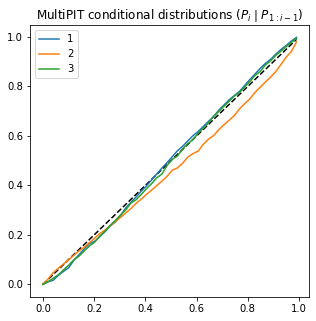

In [8]:
# train regressors to estimate the multiPIT conditionals
P_1_maf_train = norm.cdf(
    maf._transform(datasets["cal"])[0][:, 0].detach().numpy()
)  # F_N(T^{-1}(x)_1)
P_2_maf_train = norm.cdf(
    maf._transform(datasets["cal"])[0][:, 1].detach().numpy()
)  # F_N(T^{-1}(x)_2)
P_3_maf_train = norm.cdf(
    maf._transform(datasets["cal"])[0][:, 2].detach().numpy()
)  # F_N(T^{-1}(x)_3)
alphas = np.linspace(0, 0.99, 50)
pit_values_train = [
    np.array([(P_1_maf_train.reshape(-1, 1) < alpha).astype(int) for alpha in alphas]),
    np.array([(P_2_maf_train.reshape(-1, 1) < alpha).astype(int) for alpha in alphas]),
    np.array([(P_3_maf_train.reshape(-1, 1) < alpha).astype(int) for alpha in alphas]),
]

clfs = multiPIT_regression_baseline(alphas=alphas, pit_values_train=pit_values_train)

# eval regressors and plot the pp-plot for the multiPIT conditionals
pit_eval = [
    np.array([(P_1_maf.reshape(-1, 1) < alpha).astype(int) for alpha in alphas]),
    np.array([(P_2_maf.reshape(-1, 1) < alpha).astype(int) for alpha in alphas]),
    np.array([(P_3_maf.reshape(-1, 1) < alpha).astype(int) for alpha in alphas]),
]
plt.plot(alphas, alphas, "--", color="black")
z_maf_1 = [np.mean(P_1_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_maf_1, label="1")
# r_alpha_2_context = np.array(z_maf_1).reshape(-1,1)
r_alpha_2 = infer_multiPIT_r_alphas_baseline(
    np.concatenate(pit_eval[:1], axis=2), clfs[1]
)
pd.Series(r_alpha_2).plot(label="2")
# r_alpha_3_context = np.concatenate([np.array(z_maf_1).reshape(-1,1), np.array(z_maf_2).reshape(-1,1)], axis=1)
r_alpha_3 = infer_multiPIT_r_alphas_baseline(
    np.concatenate(pit_eval[:2], axis=2), clfs[2]
)
pd.Series(r_alpha_3).plot(label="3")
plt.legend()
plt.title(r"MultiPIT conditional distributions ($P_i \mid P_{1:i-1}$)")
plt.show()


In [16]:
pit_eval = [
    np.array([(P_1_maf.reshape(-1, 1) < alpha).astype(int) for alpha in alphas]),
    np.array([(P_2_maf.reshape(-1, 1) < alpha).astype(int) for alpha in alphas]),
    np.array([(P_3_maf.reshape(-1, 1) < alpha).astype(int) for alpha in alphas]),
]
np.concatenate([pit_values_train[j][25] for j in range(i)], axis=1).shape
pit_values_train[i][25][:,0].shape

(5000,)

/opt/miniconda3/envs/nflows/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


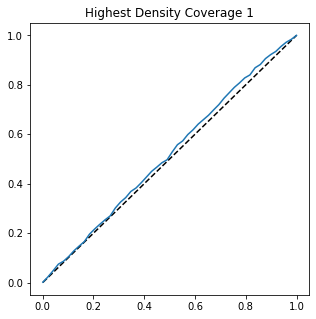

In [9]:
# Highest Density Coverage 1: 
# Plot the probability of a true sample to be in the alpha-hdr of the estimator q:
# P_{x_0}(q(x_0) > hdr_level(q,alpha))

x_ = torch.linspace(-10, 10, 100)
X1, X2, X3 = torch.meshgrid(x_, x_, x_)
samples = torch.cat([X1.reshape(-1, 1), X2.reshape(-1, 1), X3.reshape(-1, 1)], dim=1)

pdf = maf._log_prob(samples, context=None).exp()
alphas = np.linspace(0.001,1,50)
coverage = []
for alpha in alphas:
    hdr_level = highest_density_level(pdf, alpha)
    coverage.append(np.array((torch.exp(maf.log_prob(datasets['test'])) > hdr_level)*1).mean())

plt.plot(alphas,alphas, '--', color='black')
plt.plot(alphas, coverage)
plt.title('Highest Density Coverage 1')
plt.show()

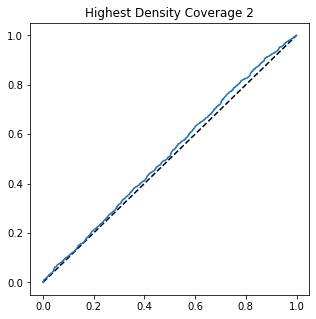

In [10]:
# Highest Density Coverage 2:
# Same as before but via MC-estimation: 
# We compute the proportion of samples x ~ q having a higher estimated density than x_0: 
# E_x[I_{q(x)>q(x_0)}] 
    
# By computing this for a large number of x_0, covering the space of the true distribution p(x),
# we get the expected coverage (or levels) over all possible covergage levels in [0,1].

levels, coverages = highest_density(maf, datasets['test'])
plt.plot(alphas,alphas, '--', color='black')
plt.plot(levels, coverages)
plt.title('Highest Density Coverage 2')
plt.show()

## Eval on FALSE data distribution

We keep the same trained MAF, but assume that the true data distribution is different than the samples the maf was trained on.

### PP-plots


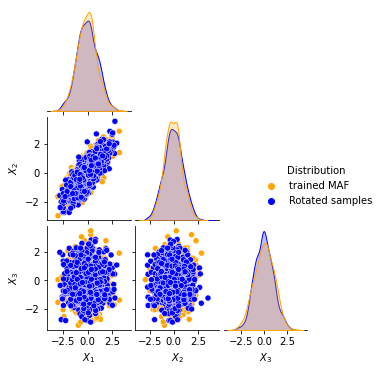

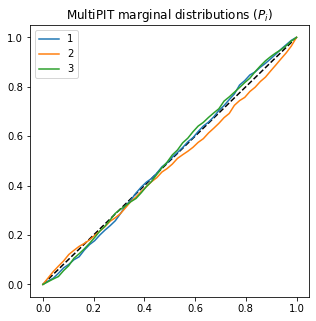

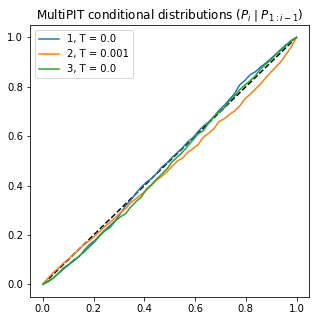

/opt/miniconda3/envs/nflows/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


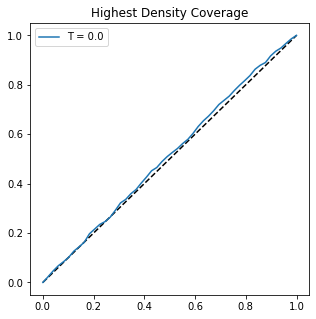

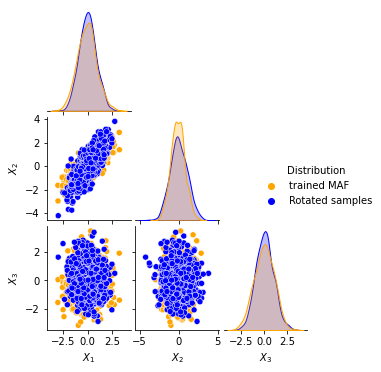

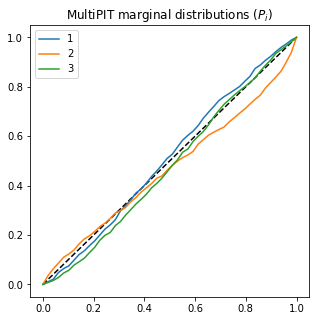

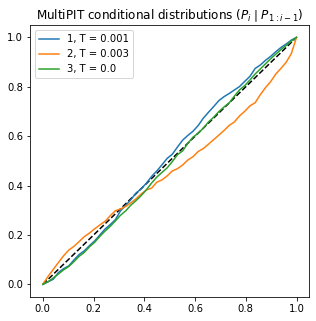

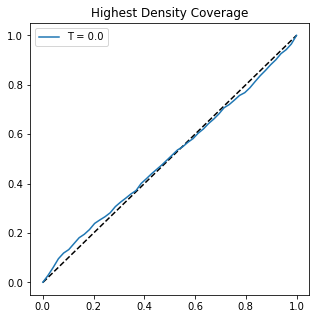

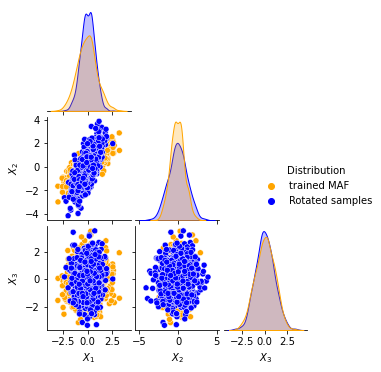

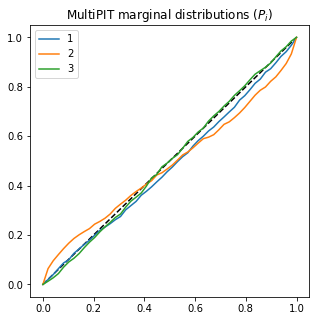

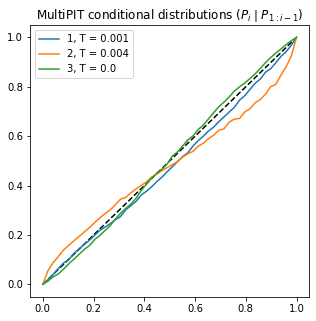

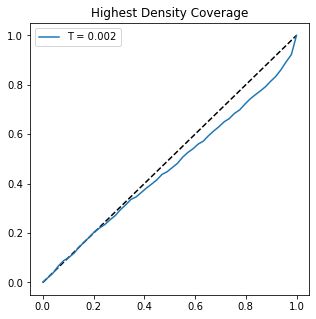

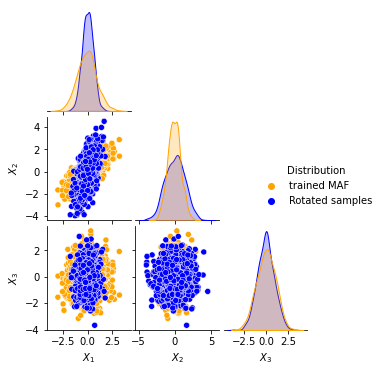

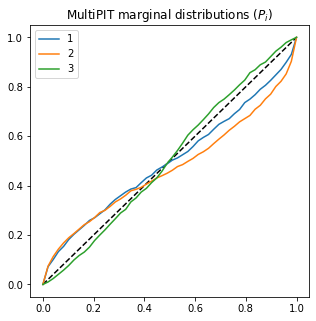

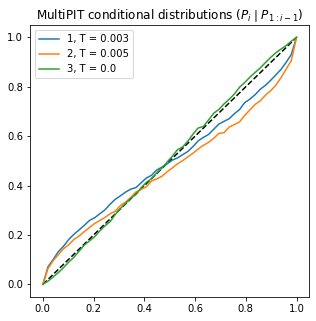

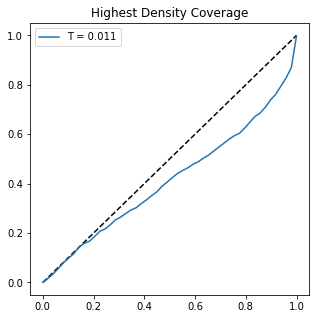

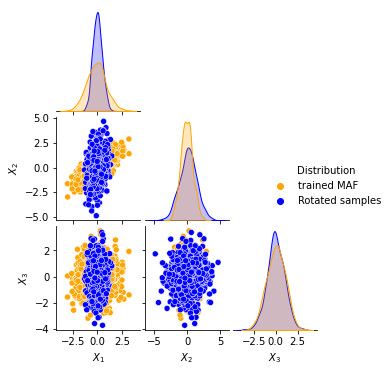

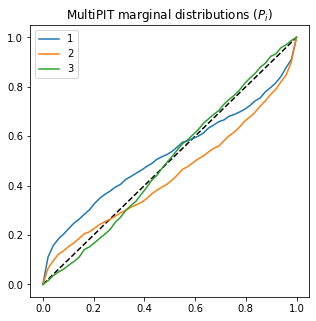

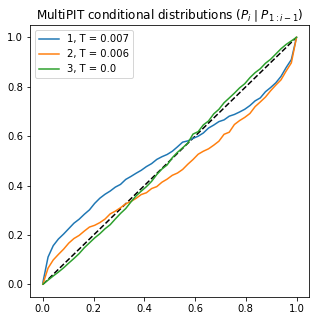

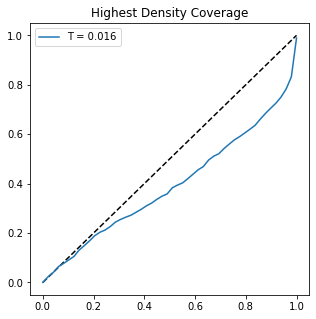

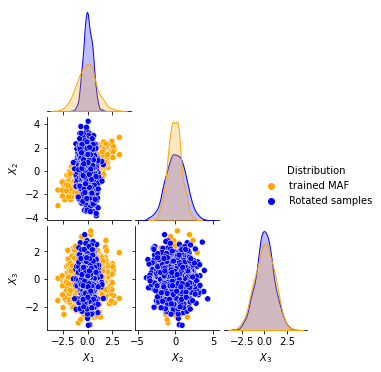

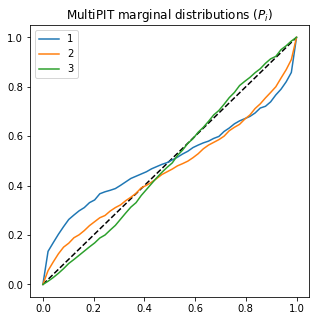

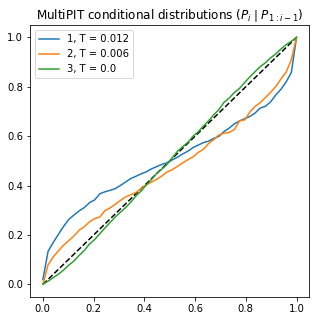

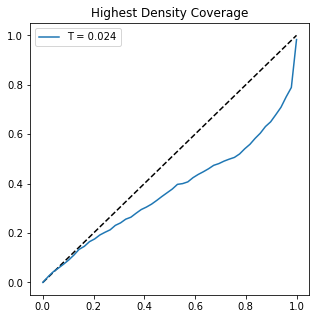

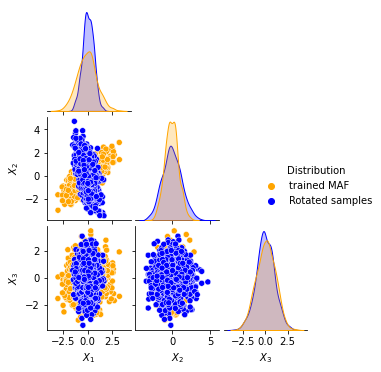

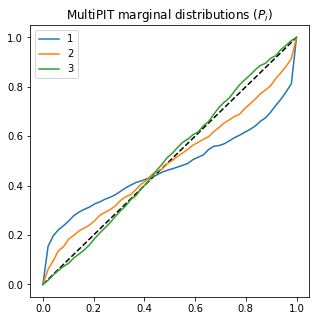

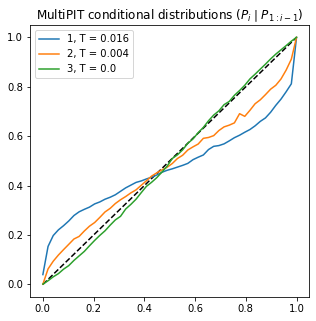

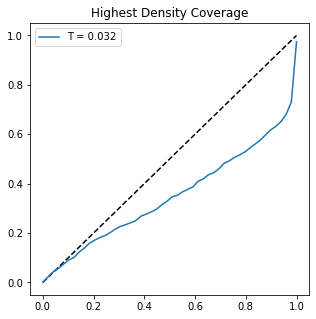

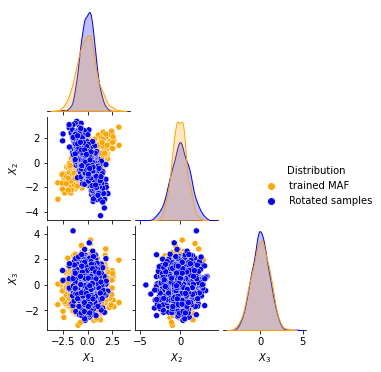

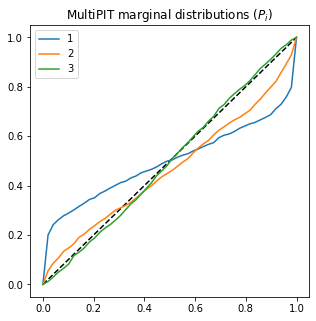

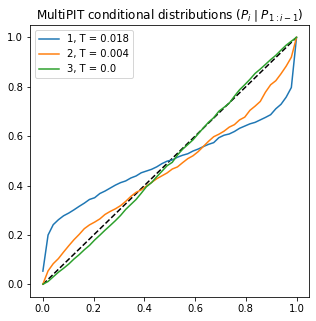

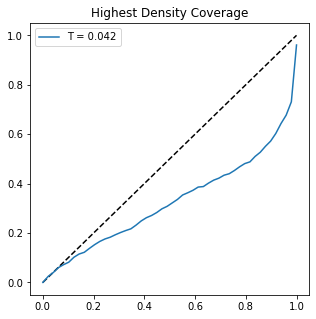

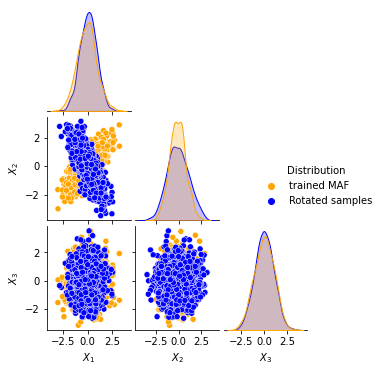

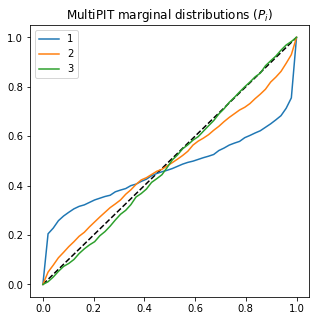

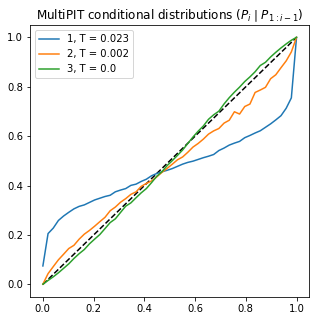

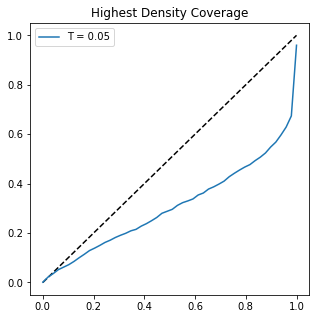

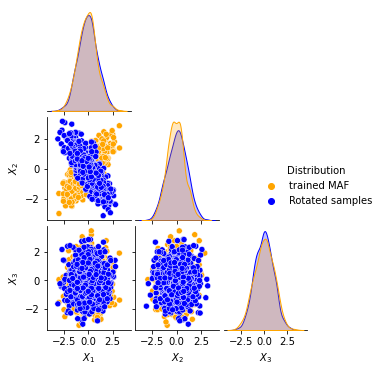

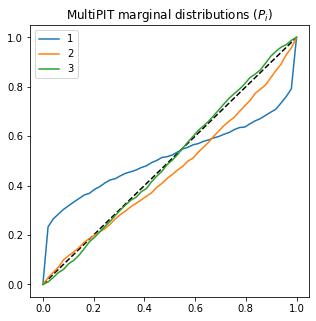

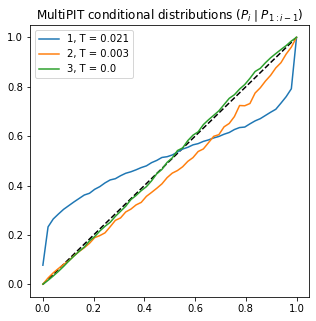

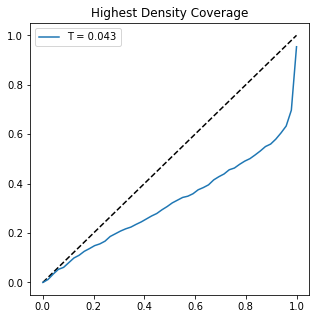

In [10]:
# Plot distribution and pp-plots of
# - the target distribution (here the false distribution) and
# - the learned maf (trained on the original data)

# Pairplot
columns = [r"$X_1$", r"$X_2$", r"$X_3$"]

df_maf["Distribution"] = "trained MAF"

test_statistics_multiPIT = {}
test_statistics_multiPIT['dim_1'] ={}
test_statistics_multiPIT['dim_2'] ={}
test_statistics_multiPIT['dim_3'] ={}
test_statistics_hdr = {}
for i in range(len(angles)):
    samples_false_cal = false_mvns_list[i].rvs(cal_size)
    samples_false_test = false_mvns_list[i].rvs(test_size)

    df_false = pd.DataFrame(samples_false_test, columns=columns)
    df_false["Distribution"] = "Rotated samples"

    dfs = pd.concat([df_maf, df_false], ignore_index=True)

    g = sns.pairplot(dfs, hue="Distribution", corner=True, palette={"Rotated samples":"blue", "trained MAF": "orange"})
    # g.fig.suptitle("rotation angle = "+str(thetas[i]))
    g.fig.set_size_inches(5,5)
    plt.show()

    samples_false_test = torch.FloatTensor(samples_false_test)
    samples_false_cal = torch.FloatTensor(samples_false_cal)

    # MAF transformation on false samples
    P_1_maf = norm.cdf(maf._transform(samples_false_test)[0][:, 0].detach().numpy())  # 1D
    P_2_maf = norm.cdf(maf._transform(samples_false_test)[0][:, 1].detach().numpy())  # 1D
    P_3_maf = norm.cdf(maf._transform(samples_false_test)[0][:, 2].detach().numpy())  # 1D

    # plot pp_plots variables 1,2,3
    alphas = np.linspace(0,1,50)
    plt.plot(alphas,alphas, '--', color='black')
    z_maf_1 = [np.mean(P_1_maf < alpha) for alpha in alphas]
    plt.plot(alphas, z_maf_1, label='1')
    z_maf_2 = [np.mean(P_2_maf < alpha) for alpha in alphas]
    plt.plot(alphas, z_maf_2, label='2')
    z_maf_3 = [np.mean(P_3_maf < alpha) for alpha in alphas]
    plt.plot(alphas, z_maf_3, label='3')
    plt.legend()
    plt.title(r'MultiPIT marginal distributions ($P_i$)')

    plt.show()

    P_1_maf_train = norm.cdf(maf._transform(samples_false_cal)[0][:, 0].detach().numpy())  # 1D
    P_2_maf_train = norm.cdf(maf._transform(samples_false_cal)[0][:, 1].detach().numpy())  # 1D
    P_3_maf_train = norm.cdf(maf._transform(samples_false_cal)[0][:, 2].detach().numpy())  # 1D

    # pit_values_train = [P_1_maf_train.reshape(-1,1), P_2_maf_train.reshape(-1,1), P_3_maf_train.reshape(-1,1)]
    pit_values_train = [
        np.array([(P_1_maf_train.reshape(-1, 1) < alpha).astype(int) for alpha in alphas]),
        np.array([(P_2_maf_train.reshape(-1, 1) < alpha).astype(int) for alpha in alphas]),
        np.array([(P_3_maf_train.reshape(-1, 1) < alpha).astype(int) for alpha in alphas]),
    ]
    alphas = np.linspace(0.0001, 1,50)
    clfs = multiPIT_regression_baseline(alphas = alphas, pit_values_train=pit_values_train)

    # pit_values_eval = [P_1_maf.reshape(-1,1), P_2_maf.reshape(-1,1), P_3_maf.reshape(-1,1)]
    pit_eval = [
        np.array([(P_1_maf.reshape(-1, 1) < alpha).astype(int) for alpha in alphas]),
        np.array([(P_2_maf.reshape(-1, 1) < alpha).astype(int) for alpha in alphas]),
        np.array([(P_3_maf.reshape(-1, 1) < alpha).astype(int) for alpha in alphas]),
    ]
    plt.plot(alphas,alphas, '--', color='black')
    z_maf_1 = np.array([np.mean(P_1_maf < alpha) for alpha in alphas])
    test_statistics_multiPIT['dim_1'][i] = np.round(((z_maf_1 - alphas) ** 2).sum() / len(alphas), 3)
    plt.plot(alphas, z_maf_1, label=f'1, T = {test_statistics_multiPIT["dim_1"][i]}')
    # r_alpha_2_context = np.array(z_maf_1).reshape(-1,1)
    r_alpha_2 = infer_multiPIT_r_alphas_baseline(np.concatenate(pit_eval[:1],axis=2), clfs[1])
    r_alpha_2[alphas[-1]] = 1
    test_statistics_multiPIT['dim_2'][i] = np.round(compute_test_statistic(r_alpha_2), 3)
    pd.Series(r_alpha_2).plot(label=f'2, T = {test_statistics_multiPIT["dim_2"][i]}')
    # r_alpha_3_context = np.concatenate([np.array(z_maf_1).reshape(-1,1), np.array(z_maf_2).reshape(-1,1)], axis=1)
    r_alpha_3 = infer_multiPIT_r_alphas_baseline(np.concatenate(pit_eval[:2],axis=2), clfs[2])
    r_alpha_3[alphas[-1]] = 1
    test_statistics_multiPIT['dim_3'][i] = np.round(compute_test_statistic(r_alpha_3), 3)
    pd.Series(r_alpha_3).plot(label=f'3, T = {test_statistics_multiPIT["dim_3"][i]}')
    plt.legend()
    plt.title(r'MultiPIT conditional distributions ($P_i \mid P_{1:i-1}$)')
    plt.show()

    x_ = torch.linspace(-10, 10, 100)
    X1, X2, X3 = torch.meshgrid(x_, x_, x_)
    samples = torch.cat([X1.reshape(-1, 1), X2.reshape(-1, 1), X3.reshape(-1, 1)], dim=1)

    pdf = maf._log_prob(samples, context=None).exp()
    
    # alphas = np.linspace(0.001,1,50)
    coverage = []
    for alpha in alphas:
        hdr_level = highest_density_level(pdf, alpha)
        c = np.array((torch.exp(maf.log_prob(samples_false_test)) > hdr_level)*1).mean()
        coverage.append(c)
    test_statistics_hdr[i] = np.round(((coverage - alphas) ** 2).sum() / len(alphas), 3)

    plt.plot(alphas,alphas, '--', color='black')
    plt.plot(alphas, coverage, label=f'T = {test_statistics_hdr[i]}')
    plt.title('Highest Density Coverage')
    plt.legend()
    plt.show()

    # levels, coverages = highest_density(maf, samples_false_test)
    # plt.plot(alphas,alphas, '--', color='black')
    # plt.plot(levels, coverages)
    # plt.title('Highest Density Coverage (MC-approx)')
    # plt.show()

### Test statistics

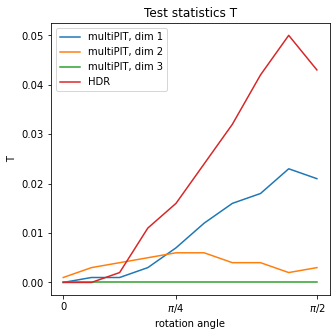

In [12]:
pd.Series(test_statistics_multiPIT['dim_1']).plot(label='multiPIT, dim 1')
pd.Series(test_statistics_multiPIT['dim_2']).plot(label='multiPIT, dim 2')
pd.Series(test_statistics_multiPIT['dim_3']).plot(label='multiPIT, dim 3')
pd.Series(test_statistics_hdr).plot(label='HDR')
plt.title('Test statistics T')
plt.legend()
plt.xticks([0,4,9],labels=['0',r'$\pi/4$',r'$\pi/2$'])
plt.xlabel('rotation angle')
plt.ylabel('T')
plt.show()